<a href="https://colab.research.google.com/github/adarsh-meher/COVID-Global-Forecasting/blob/master/COVID_19_Global_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
#import shutil
#shutil.rmtree(os.getcwd())
!git clone https://github.com/adarsh-meher/COVID-Global-Forecasting.git
import os
os.chdir('/content/COVID-Global-Forecasting/')

fatal: destination path 'COVID-Global-Forecasting' already exists and is not an empty directory.


In [124]:
#!python -m pip install "dask[complete]" 
!pip install pyflux
!pip install pydlm
!pip install tensorflow_probability
!pip install fbprophet

In [0]:
import pandas as pd
import numpy as np
import tensorflow_probability as tfp
from fbprophet import Prophet
from pydlm import dlm, trend, seasonality
import pyflux as pf
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
train['Date'] = train['Date'].map(lambda x: dt.strptime(x,"%m/%d/%Y"))
test['Date'] = test['Date'].map(lambda x: dt.strptime(x,"%Y-%m-%d"))

In [128]:
print('Starting date Train : %s' % (train['Date'].min()))
print('End date Train: %s' % (train['Date'].max()))
print('Starting date Test : %s' % (test['Date'].min()))
print('End date Test: %s' % (test['Date'].max()))

Starting date Train : 2020-01-22 00:00:00
End date Train: 2020-03-24 00:00:00
Starting date Test : 2020-03-12 00:00:00
End date Test: 2020-04-23 00:00:00


In [0]:
#### Splitting train data into train and validation. validation will contain data from 12-03-2020 till 23-04-2020.
train_date_range = pd.date_range(start = '2020-01-22',end = '2020-03-11',freq = 'D')
val_date_range = pd.date_range(start = '2020-03-12',end = '2020-03-25',freq = 'D')
test_date_range = pd.date_range(start = '2020-03-26',end = '2020-04-23',freq = 'D')

train_data = train[train['Date'].isin(train_date_range)]
val_data = train[train['Date'].isin(val_date_range)]
test_data = test[test['Date'].isin(test_date_range)]

In [130]:
train_data.info()
#### Nulls in Province/State. No nulls in any cols

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 17878
Data columns (total 8 columns):
Id                14200 non-null int64
Province/State    6500 non-null object
Country/Region    14200 non-null object
Lat               14200 non-null float64
Long              14200 non-null float64
Date              14200 non-null datetime64[ns]
ConfirmedCases    14200 non-null int64
Fatalities        14200 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 998.4+ KB


In [0]:
#### Number of provinces in each country

grps = train_data.groupby(['Country/Region'])
cnt_states = pd.DataFrame(columns = ['Country','Num States'],index=range(train_data['Country/Region'].nunique()))
k = 0
for name,grp in grps:
  t1 = pd.DataFrame(grp['Province/State'])
  cnt_states.loc[k,'Country'] = name
  cnt_states.loc[k,'Num States'] = int(t1[~pd.isna(t1['Province/State'])].nunique()) if len(t1[~pd.isna(t1['Province/State'])].nunique())!=0 else 0
  k += 1

cnt_states.sort_values(by = 'Num States',ascending = False,inplace = True)  

In [0]:
country_with_states = cnt_states[cnt_states['Num States']>0]['Country'].tolist()
#### Countries with some states provided:  ['US','China','Canada','Australia','France','United Kingdom','Netherlands','Denmark','Cruise Ship']

In [0]:
#### Countries with zero confirmed/fatal cases
def extract_cnt_with_zero_cases(data):
  def extract_info(x):
    x2 = pd.DataFrame({'Total Confirmed cases' : x['ConfirmedCases'].sum(),
                                'Total fatalities cases' : x['Fatalities'].sum(),
                                  'total Confirmed + fatal' : x['ConfirmedCases'].sum()+x['Fatalities'].sum(),
                                'Min Confirmed' : x['ConfirmedCases'].min(),
                                'Max Confirmed' : x['ConfirmedCases'].max(),
                                'Min fatalities' : x['Fatalities'].min(),
                                'Max fatalities' : x['Fatalities'].max()},index = [0])
    return x2

  df2 = data.groupby(['Country/Region'])[['ConfirmedCases' ,'Fatalities']].apply(lambda x : extract_info(x) )
  df2.sort_values(by = ['total Confirmed + fatal'],ascending = True,inplace = True)
  return df2

In [0]:
df2 = extract_cnt_with_zero_cases(train_data)
countries_with_zero_cases = [ i[0] for i in df2[df2['total Confirmed + fatal'] == 0].index.values.tolist() ]

In [0]:
countries_no_state = train_data[~train_data['Country/Region'].isin(country_with_states+countries_with_zero_cases)]['Country/Region'].unique().tolist()

In [0]:
#### Extracting last 10 percetile countries with high total confirmed + fatal cases to assess their trend
per_90_cases = np.percentile(df2['total Confirmed + fatal'],q = 90)
high_cases_cntry = [ i[0] for i in df2[df2['total Confirmed + fatal']>=per_90_cases].index.values.tolist() ]

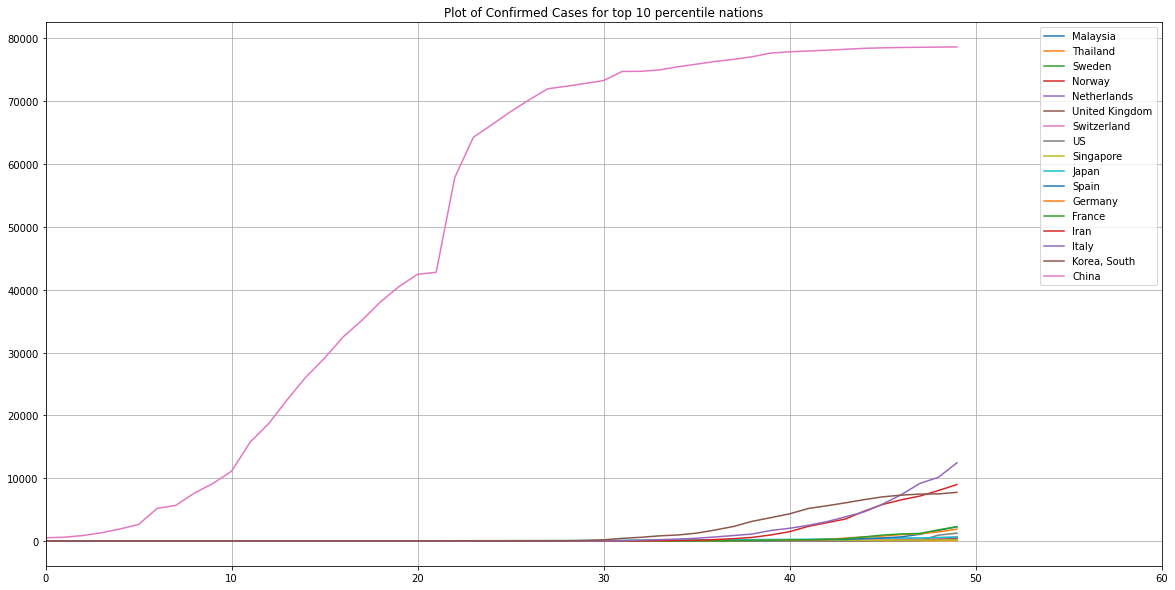

In [137]:
train_data.sort_values(by = ['Country/Region','Province/State','ConfirmedCases','Fatalities'],ascending = True,inplace = True)
plt.figure(figsize = (20,10))
for c in high_cases_cntry:
  df3 = train_data[train_data['Country/Region'] == c].groupby(['Country/Region','Date'])['ConfirmedCases'].apply(lambda x: np.sum(x))
  plt.plot(df3.values,label = c)
  plt.xlim(0,60)
  #plt.ylim(ymin,ymax+1000)
  plt.legend(loc = "upper_left")

plt.grid()
plt.title('Plot of Confirmed Cases for top 10 percentile nations')
plt.show()

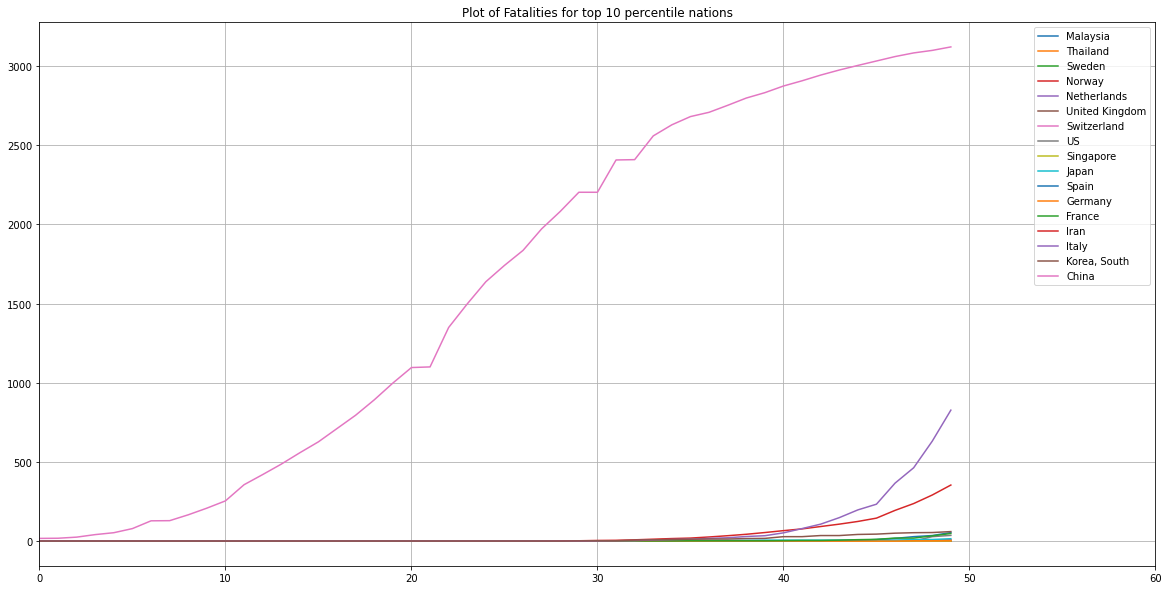

In [138]:
plt.figure(figsize = (20,10))
for c in high_cases_cntry:
  df3 = train_data[train_data['Country/Region'] == c].groupby(['Country/Region','Date'])['Fatalities'].apply(lambda x: np.sum(x))
  plt.plot(df3.values,label = c)
  plt.xlim(0,60)
  #plt.ylim(ymin,ymax+1000)
  plt.legend(loc = "upper_left")

plt.grid()
plt.title('Plot of Fatalities for top 10 percentile nations')
plt.show()

#### Top affected nations : China, Italy, Iran, South Korea

In [0]:
#### Creating date based features

def create_time_feats(df):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    return df


train_data = create_time_feats(train_data)
val_data = create_time_feats(val_data)
test_data = create_time_feats(test_data)

In [0]:
#### Creating lags (1-6) of confirmed cases and fatalities

def create_lags(data,cols,min_lag = 1,max_lag = 6):
  for c in cols:
    for i in range(min_lag,max_lag+1,1):
      data[c+'_Lag_'+str(i)] = data[c].shift(i)
    
  return data

#train_data = create_lags(train_data,cols = ['ConfirmedCases','Fatalities'])
#val_data = create_lags(train_data,cols = ['ConfirmedCases','Fatalities'])
#test_data = create_lags(train_data,cols = ['ConfirmedCases','Fatalities'])

In [0]:
def create_dummy(data,cols):
  X = pd.get_dummies(data = data,columns = cols,drop_first=False)
  return X

In [0]:
###### Creating CountVector/TF-IDF of top 5 neighbouring states/regions obtained from lat/long coordinates.
from shapely import wkt
from shapely import geometry, ops
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def extract_neigh_regions_vect(df):

  df['Local_Coordinate'] = df.apply(lambda x:Point(x.Lat, x.Long), axis=1)
  df.Local_Coordinate = df.Local_Coordinate.astype(str)

  df1 = df.groupby(['Country/Region'])['ConfirmedCases'].sum().reset_index()
  df  = df.merge(df1, on=['Country/Region'], how='left', suffixes=('', '_country'))
  df2 = df.groupby(['Country/Region', 'Local_Coordinate'])['ConfirmedCases'].sum().reset_index()
  df  = df.merge(df2, on=['Country/Region', 'Local_Coordinate'], how='left', suffixes=('', '_region'))

  df3 = df[["Province/State", "Country/Region", 'Local_Coordinate']]
  df3 = df3.drop_duplicates()
  df3.Local_Coordinate = df3.Local_Coordinate.apply(lambda x:wkt.loads(x))

  def process(df, df1):
      dist={}
      for i, j in df1.iterrows():
          dist[str(j["Country/Region"])+'_'+str(j["Province/State"])] = j.Local_Coordinate.distance(df.Local_Coordinate) 
      df['dist_dict'] = dist
      return df


  df4 = df3.apply(lambda x:process(x,df3), axis=1)
  df4.dist_dict = df4.dist_dict.apply(lambda x:sorted(x.items(), key=lambda x: x[1]))
  df4['nearest_country'] = df4.dist_dict.apply(lambda x:[i[0] for i in x[:5]])
  df4.nearest_country = df4.nearest_country.apply(lambda x:str(x[0])+' '+str(x[1])+' '+str(x[2])+' '+str(x[3])+' '+str(x[4]))
  df5 = df4['nearest_country'].to_string(header=False, index=False).split('\n')

  cv = CountVectorizer()
  count_vec = cv.fit_transform(df5)

  tfidf = TfidfVectorizer()
  tfidf_vec = tfidf.fit_transform(df5)

  return df4,count_vec.toarray(),tfidf_vec.toarray()



In [0]:
#df4,count_vec,tfidf_vec = extract_neigh_regions_vect(train_data)
df4.index = range(df4.shape[0])
count_vec = pd.concat([df4[['Province/State','Country/Region']],pd.DataFrame(count_vec,columns = [ 'Count_Vec_'+str(i) for i in range(count_vec.shape[1])],index = range(count_vec.shape[0]))],axis = 1)
tfidf_vec = pd.concat([df4[['Province/State','Country/Region']],pd.DataFrame(tfidf_vec,columns = [ 'Tfidf_Vec_'+str(i) for i in range(tfidf_vec.shape[1])],index = range(count_vec.shape[0]))],axis = 1)

In [0]:
#### Extracting past 3/5/7 day average of percentage change in confirmed cases and fatalities.
def extract_per_ch_avg(data,target_col,pct_ch_shift = 1,periods = [3,5,7]):
  data[target_col+'_Pct_Ch'] = data[target_col].pct_change(periods=1)
  data[target_col+'_Pct_Ch'] = data[target_col+'_Pct_Ch'].replace(np.nan, 0)
  data[target_col+'_Pct_Ch'] = data[target_col+'_Pct_Ch'].replace(np.inf, 0)

  for i in periods:
   data[target_col+'_Pct_Ch_'+str(i)] = data[target_col+'_Pct_Ch'].rolling(window=i).mean()
  

In [204]:
train_data.Fatalities.pct_change(periods=1)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
17874   NaN
17875   NaN
17876   NaN
17877   NaN
17878   NaN
Name: Fatalities, Length: 14200, dtype: float64

# **Modelling Confirmed and Fatal cases**

In [0]:
sub_df = test.drop(['Lat','Long'],axis = 1)
sub_df['ConfirmedCases'] = [0]*sub_df.shape[0]
sub_df['Fatalities'] = [0]*sub_df.shape[0]

In [0]:
def create_train_test_data(train,test,target_col,cols_to_remove = None,cols_to_keep = None):
  if cols_to_remove != None:
    train = train.drop(cols_to_remove,axis  = 1)
    test = test.drop(cols_to_remove,axis  = 1 )
  
  if cols_to_keep!= None:
    cols_to_remove = [ x for x in train.columns if x not in cols_to_keep]
    train = train.drop(cols_to_remove,axis  = 1)
    test = test.drop(cols_to_remove,axis  = 1 )

  train['flag'] = ['train']*train.shape[0]
  test['flag'] = ['test']*test.shape[0]
  total_data = pd.concat([train,test],axis = 0)
  total_new = create_lags(total_data,cols = target_col)
  train_new = total_new[total_new['flag'] == 'train'].drop(['flag'],axis = 1)
  test_new = total_new[total_new['flag'] == 'test'].drop(['flag'],axis = 1)

  return train_new.dropna(),test_new
  

In [202]:
cols_to_remove = ['Id','Lat','Long']

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ConfirmedCases_Lag_1,ConfirmedCases_Lag_2,ConfirmedCases_Lag_3,ConfirmedCases_Lag_4,ConfirmedCases_Lag_5,ConfirmedCases_Lag_6,Fatalities_Lag_1,Fatalities_Lag_2,Fatalities_Lag_3,Fatalities_Lag_4,Fatalities_Lag_5,Fatalities_Lag_6,Local_Coordinate
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0,0,2,1,1,2020,22,22,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (33 65)
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0,0,3,1,1,2020,23,23,4,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,POINT (33 65)
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0,0,4,1,1,2020,24,24,4,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,POINT (33 65)
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0,0,0,5,1,1,2020,25,25,4,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,POINT (33 65)
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0,0,0,6,1,1,2020,26,26,4,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,POINT (33 65)


In [203]:
train_data.Local_Coordinate.values[0]

'POINT (33 65)'